# [📖 Main Menu](index.html)

In [1]:
using StatsBase, DataFrames, DataFrameMacros
using RCall, CategoricalArrays, TexTables
using Distributions, Gadfly, Compose, MLJ
using HypothesisTests, CSV, StableRNGs
using AnovaGLM, Effects, MultipleTesting

using MLJ: schema

In [2]:
include("pubh.jl")
set_default_plot_size(15cm, 12cm)
@rimport pubh
@rlibrary readr

# Confidence Intervals around the Mean

In [3]:
bernard = rcopy(R"pubh::Bernard")
bernard |> schema

┌──────────┬────────────────────────────┬──────────────────────────────────┐
│ names    │ scitypes                   │ types                            │
├──────────┼────────────────────────────┼──────────────────────────────────┤
│ id       │ Continuous                 │ Float64                          │
│ treat    │ Multiclass{2}              │ CategoricalValue{String, UInt32} │
│ race     │ Multiclass{3}              │ CategoricalValue{String, UInt32} │
│ fate     │ Multiclass{2}              │ CategoricalValue{String, UInt32} │
│ apache   │ Union{Missing, Continuous} │ Union{Missing, Float64}          │
│ o2del    │ Union{Missing, Continuous} │ Union{Missing, Float64}          │
│ followup │ Continuous                 │ Float64                          │
│ temp0    │ Continuous                 │ Float64                          │
│ temp10   │ Union{Missing, Continuous} │ Union{Missing, Float64}          │
└──────────┴────────────────────────────┴──────────────────────────────────┘

Let's take a look at the distribution of baseline temperature.

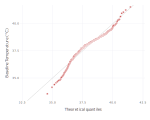

In [4]:
#| label: fig-fig1
#| fig-cap: "Distribution of baseline temperature."
qq_plot(bernard.temp0; ylab="Baseline Temperature (°C)")

Let's assume normality and estimate the 95% CI around the mean baseline temperature for all patients.

In [5]:
cis(bernard.temp0)

(outcome = 38.0149207202506,
 lower = 37.91149233237877,
 upper = 38.11834910812243,)

What about the 95% CI around the mean temperature after 36 hr of treatment?

In [6]:
cis(@subset(bernard, !ismissing(:temp10)).temp10)

(outcome = 37.31448060654226,
 lower = 37.21970170268702,
 upper = 37.409259510397504,)

In [7]:
pubh.bst(bernard.temp10) |> rcopy

1×5 DataFrame
 Row │ stat    estimate  %CI      lower    upper   
     │ String  Float64   Float64  Float64  Float64 
─────┼─────────────────────────────────────────────
   1 │ mean       37.31     95.0    37.22     37.4

## Tests for Means

### One-sample $t$-tests

Perform the following two-sided one-sample $t$-test, where the normal core temperature is 37$^{\circ}C$. Note that because sepsis was diagnosed in this case by a set of symptoms including fever, you would be very surprised if there were no evidence of a difference between the mean baseline temperature of sepsis patients and the normal body temperature.

If we define $\bar x$ as the mean baseline temperature, our two hypotheses are:

-   $H_0: \bar x = 37^{\circ}C$
-   $H_A: \bar x \neq 37^{\circ}C$

Take a look at the help file of `t.test` to get familiarised with its options. By default, we are using a two-sided test, with a significant $\alpha=0.05$ (95% CI).

In [8]:
OneSampleTTest(bernard.temp0, 37)

One sample t-test
-----------------
Population details:
    parameter of interest:   Mean
    value under h_0:         37
    point estimate:          38.0149
    95% confidence interval: (37.91, 38.12)

Test summary:
    outcome with 95% confidence: reject h_0
    two-sided p-value:           <1e-60

Details:
    number of observations:   455
    t-statistic:              19.23306214688628
    degrees of freedom:       454
    empirical standard error: 0.05276958564889316


## Paired $t$-tests

In [9]:
placebo = @select(
  @subset(bernard, :treat == "Placebo"),
  :temp0, :temp10
)
dropmissing!(placebo);

In [10]:
OneSampleTTest(placebo.temp10, placebo.temp0)

One sample t-test
-----------------
Population details:
    parameter of interest:   Mean
    value under h_0:         0
    point estimate:          -0.498563
    95% confidence interval: (-0.6428, -0.3543)

Test summary:
    outcome with 95% confidence: reject h_0
    two-sided p-value:           <1e-09

Details:
    number of observations:   201
    t-statistic:              -6.816054633057416
    degrees of freedom:       200
    empirical standard error: 0.07314536404958778


## Two-sample $t$-tests

Our real question of interest is to test if given Ibuprofen was statistically different from given placebo in patients with sepsis. This is a two-sided, two-sample hypothesis. The two samples are independent (treatment groups), and our variable of interest is `temp_change`.

First, we calculate the difference in temperatures.

In [11]:
bern = @select(bernard, :temp0, :temp10, :treat)
@transform!(bern, :temp_change = :temp10 - :temp0)
dropmissing!(bern);

One of the assumptions is that the distribution of `temp_change` is normal for each group. The another big assumption is that the variance is the same. To compare variances, we perform a variance test. The null hypothesis is that the ratio of the two variances is equal to one (same variance) and the alternative is that is different from one. A $p \leq 0.05$ means that there is no statistical difference between the two variances and, therefore, that the assumption of homogeneity of variances holds.

First, we perform a standard descriptive analysis on temp_change.

In [12]:
summarize_by(bern, :treat, :temp_change)

          |             | Obs |  Mean  | Std. Dev. |  Min   |  Max  
--------------------------------------------------------------------
  Placebo | temp_change | 201 | -0.499 |     1.037 | -3.278 | 2.900 
--------------------------------------------------------------------
Ibuprofen | temp_change | 198 | -1.034 |     1.133 | -4.100 | 2.500 


::: callout-note
The `R` package `pubh` has function `estat` that allow us to also generate a table of descriptive statistics.
:::

In [13]:
pubh.estat(@formula(temp_change ~ treat), data=bern) |> rcopy

2×9 DataFrame
 Row │              treat      N        Min      Max      Mean     Median   SD ⋯
     │ String       String     Float64  Float64  Float64  Float64  Float64  Fl ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ temp_change  Placebo      201.0    -3.28      2.9    -0.5     -0.5      ⋯
   2 │              Ibuprofen    198.0    -4.1       2.5    -1.03    -1.11
                                                               2 columns omitted

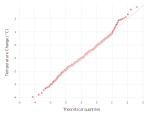

In [14]:
#| label: fig-fig2
#| fig-cap: "QQ-plot of temperature change against the standard normal distribution."
#| code-fold: true
qq_plot(bern.temp_change, ylab = "Temperature Change (°C)")

We perform a variance test with `VarianceFTest`.

In [15]:
VarianceFTest(
  @subset(bern, :treat == "Ibuprofen").temp_change,
  @subset(bern, :treat == "Placebo").temp_change
) |> pvalue |> r3

0.212

In [16]:
VarianceFTest(
  vec_group(bern, :temp_change, :treat)...
) |> pvalue |> r3

0.212

Now, let's test the null hypothesis that the mean temperature change between the two groups is the same.

In [17]:
EqualVarianceTTest(
  vec_group(bern, :temp_change, :treat)...
)

Two sample t-test (equal variance)
----------------------------------
Population details:
    parameter of interest:   Mean difference
    value under h_0:         0
    point estimate:          0.535107
    95% confidence interval: (0.3214, 0.7489)

Test summary:
    outcome with 95% confidence: reject h_0
    two-sided p-value:           <1e-05

Details:
    number of observations:   [201,198]
    t-statistic:              4.9216804918824
    degrees of freedom:       397
    empirical standard error: 0.10872455012044961


# Non Parametric tests

## Mann-Whitney

In some disciplines, researchers are not interested in the magnitude of the difference, e.g., when there is no precise knowledge of the interpretation of the scales. Under those circumstances, they may choose a priori, to use non-parametric tests for relatively small samples.

Non-parametric tests are also used when violations to the $t$-test assumptions occur.

In [18]:
energy = rcopy(R"ISwR::energy")
energy |> schema

┌─────────┬───────────────┬──────────────────────────────────┐
│ names   │ scitypes      │ types                            │
├─────────┼───────────────┼──────────────────────────────────┤
│ expend  │ Continuous    │ Float64                          │
│ stature │ Multiclass{2} │ CategoricalValue{String, UInt32} │
└─────────┴───────────────┴──────────────────────────────────┘


In [19]:
#| code-fold: true
pubh.estat(@formula(expend ~ stature), data=energy) |> rcopy

2×9 DataFrame
 Row │         stature  N        Min      Max      Mean     Median   SD        ⋯
     │ String  String   Float64  Float64  Float64  Float64  Float64  Float64   ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ expend  lean        13.0     6.13    10.88     8.07     7.9      1.24   ⋯
   2 │         obese        9.0     8.79    12.79    10.3      9.69     1.4
                                                                1 column omitted

Given that our samples are relatively small (less than 30 observations per group), the best way to graphically compare distributions is by strip charts.

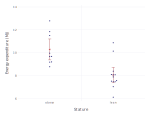

In [20]:
#| label: fig-fig3
#| fig-cap: "Comparison of energy expenditure between obese and lean women."
#| code-fold: true
strip_error(
  energy,
  :stature, :expend, 
  xlab = "Stature",
  ylab = "Energy expenditure (MJ)"
)

We can check graphically for normality. Strictly speaking, the mean difference is the one that has to be normally distributed, for simplicity, we will look at the distribution of energy for each group, as that is a good indicator about normality on the mean difference.

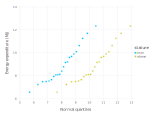

In [21]:
#| label: fig-fig4
#| fig-cap: "QQ-plots of 24 hr energy expenditure of women against the standard Normal distribution by stature status."
let
  energy_qq = DataFrames.combine(
    groupby(energy, :stature),
    :expend => (x->fit(Normal, x)) => :d
  )
  
  plot(
    energy_qq,
    x=:d, y=energy.expend, color=:stature,
    Stat.qq,
    Guide.xlabel("Normal quantiles"),
    Guide.ylabel("Energy expenditure (MJ)")
  )
end

What about variance equality?

In [22]:
VarianceFTest(
  vec_group(energy, :expend, :stature)...
) |> pvalue |> r3

0.68

The associated non-parametric test to the *t*-test is the Wilcoxon-Mann-Whitney test, more commonly known as Mann-Whitney test.

In [23]:
MannWhitneyUTest(
  vec_group(energy, :expend, :stature)...
) |> pvalue |> r3

0.002

### Paired data

Paired tests are used when there are two measurements on the same experimental unit. We will use data on pre- and post-menstrual energy intake in a group of 11 women.

In [24]:
intake = rcopy(R"ISwR::intake")
intake |> schema

┌───────┬────────────┬─────────┐
│ names │ scitypes   │ types   │
├───────┼────────────┼─────────┤
│ pre   │ Continuous │ Float64 │
│ post  │ Continuous │ Float64 │
└───────┴────────────┴─────────┘


We can start, as usual, with descriptive statistics.

In [25]:
estat(intake)

2×6 DataFrame
 Row │ Variable  n      Median   Mean     SD       CV      
     │ Symbol    Int64  Float64  Float64  Float64  Float64 
─────┼─────────────────────────────────────────────────────
   1 │ pre          11   6515.0  6753.64  1142.12    0.169
   2 │ post         11   5265.0  5433.18  1216.83    0.224

Let's work on the assumption that we are not interested in the magnitude of the difference but only if that difference is significant or not. On those circumstances and given the small sample size, we would perform a non-parametric test that would be equivalent to the paired $t$-test.

In [26]:
ApproximateSignedRankTest(
  intake.post,
  intake.pre
) |> pvalue |> r3

0.004

In [27]:
hodgkin = rcopy(R"pubh::Hodgkin")
hodgkin |> schema

┌───────┬───────────────┬──────────────────────────────────┐
│ names │ scitypes      │ types                            │
├───────┼───────────────┼──────────────────────────────────┤
│ CD4   │ Count         │ Int64                            │
│ CD8   │ Count         │ Int64                            │
│ Group │ Multiclass{2} │ CategoricalValue{String, UInt32} │
└───────┴───────────────┴──────────────────────────────────┘


In [28]:
#| code-fold: true
@transform!(
  hodgkin,
  :ratio = :CD4 / :CD8
);

In [29]:
#| code-fold: true
pubh.estat(@formula(ratio ~ Group), data=hodgkin) |> rcopy

2×9 DataFrame
 Row │         Group        N        Min      Max      Mean     Median   SD    ⋯
     │ String  String       Float64  Float64  Float64  Float64  Float64  Float ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ ratio   Non-Hodgkin     20.0     1.1      3.49     2.12     2.15     0. ⋯
   2 │         Hodgkin         20.0     0.47     3.82     1.5      1.19     0.
                                                               2 columns omitted

Let's compare the distributions of the ratios with a QQ-Plot:

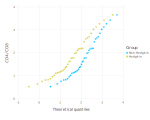

In [30]:
#| label: fig-fig6
#| fig-cap: "QQ-plot comparing the distributions of CD4/CD8 ratios between Hodking and Non-Hodgkin subjects."
let
  hodg = DataFrames.combine(
    groupby(hodgkin, :Group), 
    :ratio=>(x->fit(Normal, x))=>:d
  )

  plot(
    hodg,
    x=:d, y=hodgkin.ratio, color=:Group,
    Stat.qq,
    Guide.xlabel("Theoretical quantiles"),
    Guide.ylabel("CD4 / CD8"))
end

In [31]:
MannWhitneyUTest(
  vec_group(hodgkin, :ratio, :Group)...
) |> pvalue |> r3

0.007

# ANOVA

In [32]:
smokew = read_rds("data/smokew.rds") |> rcopy
smokew |> schema

┌─────────┬───────────────┬──────────────────────────────────┐
│ names   │ scitypes      │ types                            │
├─────────┼───────────────┼──────────────────────────────────┤
│ bweight │ Continuous    │ Float64                          │
│ smoking │ Multiclass{4} │ CategoricalValue{String, UInt32} │
└─────────┴───────────────┴──────────────────────────────────┘


We can start with descriptive statistics.

In [33]:
pubh.estat(@formula(bweight ~ smoking), data=smokew) |> rcopy

4×9 DataFrame
 Row │          smoking       N        Min      Max      Mean     Median   SD  ⋯
     │ String   String        Float64  Float64  Float64  Float64  Float64  Flo ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ bweight  Non-smoker        7.0     2.82     4.18     3.45     3.41      ⋯
   2 │          Ex-smoker         5.0     2.64     3.73     3.29     3.32
   3 │          Light-smoker      7.0     2.14     3.77     2.88     2.82
   4 │          Heavy-smoker      8.0     2.23     3.23     2.73     2.73
                                                               2 columns omitted

Given the number of observations per group, we use a strip plot to compare the four groups graphically.

In [34]:
smokew_bst = pubh.gen_bst_df(
  @formula(bweight ~ smoking), 
  data=smokew
) |> rcopy

4×4 DataFrame
 Row │ bweight  LowerCI  UpperCI  smoking      
     │ Float64  Float64  Float64  Cat…         
─────┼─────────────────────────────────────────
   1 │    3.45     3.18     3.74  Non-smoker
   2 │    3.29     2.94     3.58  Ex-smoker
   3 │    2.88     2.56     3.22  Light-smoker
   4 │    2.73     2.52     2.96  Heavy-smoker

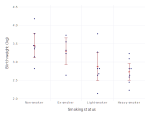

In [35]:
#| label: fig-fig8
#| fig-cap: "Comparison of birth weights of babies born from mothers with different smoking status."
strip_error(
  smokew,
  :smoking, :bweight,
  xlab = "Smoking status",
  ylab = "Birth weight (kg)"
)

## Initial assumptions

Normality can be tested using the Shapiro-Wilks test. The null hypothesis is that the distribution of the error is normal. We could look at the distribution of `bweight` for each group with QQ-plots. We will check for normality after *fitting* the model.

Homoscedasticity (homogeneity of variances) can be tested with Bartlett's or Levene's test of variance. The null hypothesis is that the variances are equal (homogeneous).

In [36]:
LeveneTest(
  vec_group(smokew, :bweight, :smoking)...
) |> pvalue |> r3

0.88

## Model

We will make ANOVA after first fitting a linear model with `lm`:

In [37]:
model_smoke = lm(@formula(bweight ~ smoking), smokew)
anova(model_smoke)

Analysis of Variance

Type 1 test / F test

bweight ~ 1 + smoking

Table:
────────────────────────────────────────────────────────────
             DOF    Exp.SS  Mean Square    F value  Pr(>|F|)
────────────────────────────────────────────────────────────
(Intercept)    1  252.76       252.76    1392.6307    <1e-21
smoking        3    2.4085       0.8028     4.4234    0.0135
(Residuals)   23    4.1744       0.1815               
────────────────────────────────────────────────────────────



## Post-hoc tests

So far, we know that there is evidence that at least the cohort of babies born from non-smoker mothers has a mean birth weight higher than those born from heavy-smoker mothers, but we do not know about any other comparison.

If we perform all possible paired *t*-test between the groups we would be increasing our error. To avoid that, we adjust our confidence intervals and *p*-values for multiple comparisons. There are several methods for making the adjustment.

We can use the function `empairs` to do the pairwise comparison and then adjust corresponding *p*-values with functions from `MultipleTesting`.

In [38]:
BH_adj(pvals) = MultipleTesting.adjust(PValues(pvals), BenjaminiHochberg());

In [39]:
empairs(model_smoke; dof=dof_residual, padjust=BH_adj)

6×6 DataFrame
 Row │ smoking                      bweight   err       dof      t         Pr( ⋯
     │ String                       Float64   Float64   Float64  Float64   Flo ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ Non-smoker > Ex-smoker       0.153143  0.249453     23.0  0.613914  0.5 ⋯
   2 │ Non-smoker > Light-smoker    0.57      0.227719     23.0  2.50309   0.0
   3 │ Non-smoker > Heavy-smoker    0.713393  0.220488     23.0  3.23552   0.0
   4 │ Ex-smoker > Light-smoker     0.416857  0.249453     23.0  1.67108   0.1
   5 │ Ex-smoker > Heavy-smoker     0.56025   0.24287      23.0  2.30679   0.0 ⋯
   6 │ Light-smoker > Heavy-smoker  0.143393  0.220488     23.0  0.650344  0.5
                                                                1 column omitted

## Diagnostics

In [40]:
smoke_perf = model_perf(model_smoke);

Normality:

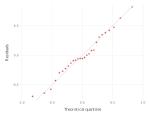

In [41]:
resid_plot(smoke_perf)

Variance:

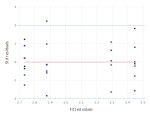

In [42]:
rvf_plot(smoke_perf)

Mean absolute error:

In [43]:
mean(abs.(smoke_perf.error)) |> r3

0.303

Mean absolute percentage error:

In [44]:
mape(smoke_perf) |> r3

0.004

Root mean square error:

In [45]:
rmse(smoke_perf) |> r3

0.393

### Effects

In *treatment* coding of categorical variables (the default), the hypothesis for the coefficients for each level is against the reference level.

In [46]:
model_smoke

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

bweight ~ 1 + smoking

Coefficients:
────────────────────────────────────────────────────────────────────────────────────
                           Coef.  Std. Error      t  Pr(>|t|)  Lower 95%   Upper 95%
────────────────────────────────────────────────────────────────────────────────────
(Intercept)             3.44714     0.161021  21.41    <1e-15   3.11404    3.78024
smoking: Ex-smoker     -0.153143    0.249453  -0.61    0.5453  -0.669176   0.362891
smoking: Light-smoker  -0.57        0.227719  -2.50    0.0199  -1.04107   -0.0989279
smoking: Heavy-smoker  -0.713393    0.220488  -3.24    0.0037  -1.16951   -0.257279
────────────────────────────────────────────────────────────────────────────────────

In *effects* coding of categorical variables, the hypothesis for the coefficients for each level is against the mean across all levels.

In [47]:
model_eff = lm(
  @formula(bweight ~ smoking), smokew;
  contrasts=Dict(:smoke => EffectsCoding())
)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

bweight ~ 1 + smoking

Coefficients:
────────────────────────────────────────────────────────────────────────────────────
                           Coef.  Std. Error      t  Pr(>|t|)  Lower 95%   Upper 95%
────────────────────────────────────────────────────────────────────────────────────
(Intercept)             3.44714     0.161021  21.41    <1e-15   3.11404    3.78024
smoking: Ex-smoker     -0.153143    0.249453  -0.61    0.5453  -0.669176   0.362891
smoking: Light-smoker  -0.57        0.227719  -2.50    0.0199  -1.04107   -0.0989279
smoking: Heavy-smoker  -0.713393    0.220488  -3.24    0.0037  -1.16951   -0.257279
────────────────────────────────────────────────────────────────────────────────────

To look at the effects, we first generate a reference grid:

In [48]:
model_des = Dict(:smoking => unique(smokew.smoking))
smoke_eff = effects(model_des, model_eff)

4×5 DataFrame
 Row │ smoking       bweight  err       lower    upper   
     │ String        Float64  Float64   Float64  Float64 
─────┼───────────────────────────────────────────────────
   1 │ Non-smoker    3.44714  0.161021  3.28612  3.60816
   2 │ Ex-smoker     3.294    0.190523  3.10348  3.48452
   3 │ Light-smoker  2.87714  0.161021  2.71612  3.03816
   4 │ Heavy-smoker  2.73375  0.150622  2.58313  2.88437

We can use the estimated effects to get a nice visual of the data:

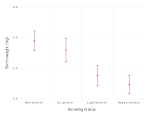

In [49]:
#| label: fig-fig9
#| fig-cap: "Effect of mother’s smoking status on babies’ birth weights. Circles indicate mean birth weights for each group and bars represent 95% CI around mean values."
effect_plot(
  smoke_eff,
  :smoking, :bweight,
  xlab = "Smoking status",
  ylab = "Birth weight (kg)"
)

## Alternatives for non-Normal data

In [50]:
air = rcopy(R"datasets::airquality") |> dropmissing
air.Month = recode(
  air.Month,
  5 => "May",
  6 => "Jun",
  7 => "Jul",
  8 => "Aug",
  9 => "Sep"
)
coerce!(air, :Month => Multiclass)
levels!(air.Month, unique(air.Month))
air |> schema

┌─────────┬───────────────┬──────────────────────────────────┐
│ names   │ scitypes      │ types                            │
├─────────┼───────────────┼──────────────────────────────────┤
│ Ozone   │ Count         │ Int64                            │
│ Solar_R │ Count         │ Int64                            │
│ Wind    │ Continuous    │ Float64                          │
│ Temp    │ Count         │ Int64                            │
│ Month   │ Multiclass{5} │ CategoricalValue{String, UInt32} │
│ Day     │ Count         │ Int64                            │
└─────────┴───────────────┴──────────────────────────────────┘


In [51]:
#| code-fold: true
pubh.estat(@formula(Ozone ~ Month), data=air) |> rcopy

5×9 DataFrame
 Row │         Month   N        Min      Max      Mean     Median   SD       C ⋯
     │ String  String  Float64  Float64  Float64  Float64  Float64  Float64  F ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ Ozone   May        24.0      1.0    115.0    24.12     18.0    22.89    ⋯
   2 │         Jun         9.0     12.0     71.0    29.44     23.0    18.21
   3 │         Jul        26.0      7.0    135.0    59.12     60.0    31.64
   4 │         Aug        23.0      9.0    168.0    60.0      45.0    41.77
   5 │         Sep        29.0      7.0     96.0    31.45     23.0    24.14    ⋯
                                                                1 column omitted

In [52]:
#| code-fold: true
LeveneTest(
  vec_group(air, :Ozone, :Month)...
) |> pvalue |> r3

0.002

### Log-transformation

We can log-transform to make the distribution closer to Normal and the variance constant between groups.

We check for normality for each group.

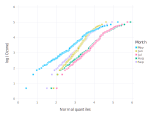

In [53]:
#| label: fig-fig11
#| fig-cap: "QQ-plots for log(Ozone) from May to September (New York, 1973)."
let
  @transform!(air, :log_oz = log.(:Ozone))
  
  air_qq = DataFrames.combine(
    groupby(air, :Month),
    :log_oz => (x -> fit(Normal, x)) => :d
  )
  
  plot(
    air_qq,
    x = :d, y = air.log_oz, color = :Month,
    Stat.qq,
    Guide.xlabel("Normal quantiles"),
    Guide.ylabel("log (Ozone)")
  )
end

Normality seems to be good enough, though we will check the distribution of the residuals later. What about homoscedasticity?

In [54]:
LeveneTest(
  vec_group(air, :log_oz, :Month)...
) |> pvalue |> r3

0.553

We can proceed to fit an ANOVA model to our data.

In [55]:
model_air = lm(
  @formula(log_oz ~ Month), air;
  contrasts=Dict(:Month => EffectsCoding())
)
anova(model_air)

Analysis of Variance

Type 1 test / F test

log_oz ~ 1 + Month

Table:
───────────────────────────────────────────────────────────
             DOF   Exp.SS  Mean Square    F value  Pr(>|F|)
───────────────────────────────────────────────────────────
(Intercept)    1  1295.21    1295.21    2170.4984    <1e-71
Month          4    19.22       4.8040     8.0506    <1e-04
(Residuals)  106    63.25       0.5967               
───────────────────────────────────────────────────────────



Diagnostics:

In [56]:
air_perf = model_perf(model_air);

Normality:

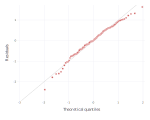

In [57]:
resid_plot(air_perf)

Variance:

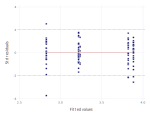

In [58]:
rvf_plot(air_perf)

In [59]:
air_des = Dict(:Month => unique(air.Month))
air_eff = effects(air_des, model_air, invlink=exp)

5×5 DataFrame
 Row │ Month   log_oz   err      lower    upper   
     │ String  Float64  Float64  Float64  Float64 
─────┼────────────────────────────────────────────
   1 │ May     16.8862  2.66266  14.2235  19.5488
   2 │ Jun     25.4489  6.55297  18.8959  32.0019
   3 │ Jul     48.6103  7.3643   41.2459  55.9746
   4 │ Aug     45.6385  7.35119  38.2873  52.9896
   5 │ Sep     24.998   3.58588  21.4121  28.5839

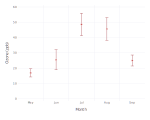

In [60]:
#| label: fig-fig12
#| fig-cap: "Comparison of mean ozone concentrations by month. Error bars represent 95% CI around mean values."
effect_plot(
  air_eff,
  :Month, :log_oz,
  xlab = "Month",
  ylab = "Ozone (ppb)"
  )

### Kruskal-Wallis test

In [61]:
fent = rcopy(R"pubh::Fentress")
fent |> schema

┌───────┬───────────────┬──────────────────────────────────┐
│ names │ scitypes      │ types                            │
├───────┼───────────────┼──────────────────────────────────┤
│ pain  │ Continuous    │ Float64                          │
│ group │ Multiclass{3} │ CategoricalValue{String, UInt32} │
└───────┴───────────────┴──────────────────────────────────┘


In [62]:
#| code-fold: true
pubh.estat(@formula(pain ~ group), data=fent) |> rcopy

3×9 DataFrame
 Row │         group        N        Min      Max      Mean     Median   SD    ⋯
     │ String  String       Float64  Float64  Float64  Float64  Float64  Float ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ pain    Untreated        6.0   -288.0    100.0   -55.0     -36.0   139. ⋯
   2 │         Relaxation       6.0     43.0    100.0    84.0      96.0    23.
   3 │         Biofeedback      6.0     37.0     91.0    70.67     74.0    19.
                                                               2 columns omitted

In [63]:
fent_bst = pubh.gen_bst_df(
  @formula(pain ~ group), 
  data=fent
) |> rcopy

3×4 DataFrame
 Row │ pain     LowerCI  UpperCI  group       
     │ Float64  Float64  Float64  Cat…        
─────┼────────────────────────────────────────
   1 │  -55.0   -162.78    36.0   Untreated
   2 │   84.0     65.16    98.67  Relaxation
   3 │   70.67    55.5     82.83  Biofeedback

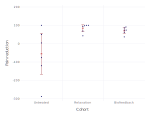

In [64]:
#| label: fig-fig13
#| fig-cap: "Comparison of mucociliary efficiency on pain reduction after dust removal."
#| code-fold: true
strip_error(
  fent,
  :group, :pain,
  xlab = "Cohort",
  ylab = "Pain reduction"
)

We are going to perform the non-parametric, Kruskal-Wallis test, to test if the differences in pain reduction between groups are statistically significant or not.

In [65]:
KruskalWallisTest(
  vec_group(fent, :pain, :group)...
) |> pvalue |> r3

0.057